In [1]:
import tensorflow as tf

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [2]:
!pip uninstall ipywidgets -y
!pip install -U ipywidgets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Found existing installation: ipywidgets 7.7.1
Uninstalling ipywidgets-7.7.1:
  Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.5 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bq

In [3]:
# import desired libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import load_dataset, DatasetDict, Dataset
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# custom visualisation styling
custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

import warnings
warnings.simplefilter("ignore")

In [4]:
# load datasets
train_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/test.csv")

In [5]:
# print num feats and datapoints
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (13144, 62)
Test shape :  (10000, 61)


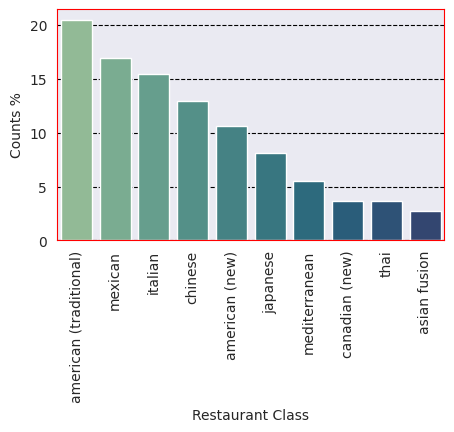

In [6]:
# check the cardinality of target distribution
rs_target = train_df['label'].value_counts(normalize=True) * 100

# target imbalance?
plt.figure(figsize=(5, 3))
sns.barplot(x=rs_target.index, y=rs_target.values, palette='crest')
plt.xlabel('Restaurant Class')
plt.xticks(rotation=90)
plt.ylabel('Counts %')
plt.show()

In [7]:
# check data-types and non-null counts of the features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13144 entries, 0 to 13143
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     13144 non-null  int64  
 1   attributes.HappyHour                   1256 non-null   object 
 2   attributes.Ambience                    11338 non-null  object 
 3   hours.Tuesday                          10412 non-null  object 
 4   postal_code                            13144 non-null  object 
 5   attributes.AgesAllowed                 12 non-null     object 
 6   attributes.GoodForDancing              1111 non-null   object 
 7   attributes.OutdoorSeating              11845 non-null  object 
 8   hours.Saturday                         10525 non-null  object 
 9   attributes.Corkage                     182 non-null    object 
 10  longitude                              13144 non-null  float64
 11  na

In [8]:
# check missing values
train_df[['label', 'review']].isna().sum()

label     0
review    0
dtype: int64

In [9]:
# check a sample review
idx = 90
print(train_df["label"][idx], '\n')
print(train_df["review"][idx])

italian 

Great place around the corner from us. We drive by this place all the time and finally decided to go in. Pizzas were tasty and made on the spot and quickly. Will definitely be coming back. This place has a really nice modern aesthetic. I got the Pesto Toscano pizza and it was pretty good. The pizza crust is thick yet airy, with just the right amount of crunch on the exterior. The pizza would have been 5 stars if it weren't for the olives they used. I usually like olives but these olives were wayyyy too strong for the pizza. They overpowered all other flavors and that was disappointing because it was a great pizza otherwise. I would probably spring for the Margherita next time. I swung by Levetto tonight to check it out, since it\'s new to our neighbourhood. I had  the Funghi Pizza, which was delicious and an amazing value at 7$ for a "personal" size- a generous portion for one person. The toppings were super fresh and as I am a bit of a stickler for pizza crust, was happy to 

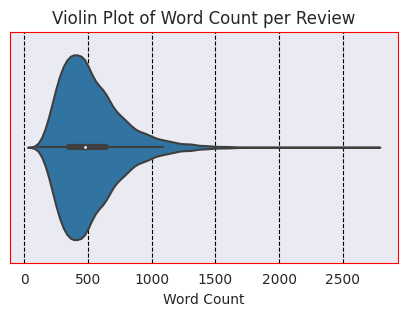

(525.5101947656725, 247.29966818641543)

In [10]:
# check review length distribution
lens = [len(review.split()) for review in train_df.review]

# calculate the statistics
plt.figure(figsize=(5,3))
sns.violinplot(x=lens)
plt.title('Violin Plot of Word Count per Review')
plt.xlabel('Word Count')
plt.show()

np.mean(lens), np.std(lens)

In [11]:
# preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

ps = PorterStemmer()
stop = set(stopwords.words('english'))

def clean_text(x, tokenise=False):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’' + '[\{\}\[\]\(\)]':
        x = x.replace(punct, '')

    tokens = x.lower().split(" ")
    tokens = [ps.stem(word) for word in tokens if word not in stop and 20>len(word)>1]

    if tokenise:
        return tokens
    
    return " ".join(tokens)

In [12]:
# apply preprocessing
train_df["review"] = train_df["review"].apply(lambda x: clean_text(x))
test_df["review"] = test_df["review"].apply(lambda x: clean_text(x))

In [13]:
# mapping of label to codes
mapped_classes = train_df['label'].astype('category')
hm_class = dict(enumerate(mapped_classes.cat.categories))
print(hm_class)

train_df['label'] = train_df.label.astype('category').cat.codes

# 1 hot encoding
# one_hot = pd.get_dummies(train_df['label'])
# train_df['label'] = one_hot.apply(lambda row: row.values, axis=1)

{0: 'american (new)', 1: 'american (traditional)', 2: 'asian fusion', 3: 'canadian (new)', 4: 'chinese', 5: 'italian', 6: 'japanese', 7: 'mediterranean', 8: 'mexican', 9: 'thai'}


In [14]:
# convert to huggingface dataset format
train_df = train_df[['review', 'label']]
test_df = test_df[['review']]

In [15]:
# convert to huggingface dataset format
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)
print(train_ds, test_ds)

Dataset({
    features: ['review', 'label'],
    num_rows: 13144
}) Dataset({
    features: ['review'],
    num_rows: 10000
})


In [16]:
# train test validation splits
train_val_splits = train_ds.train_test_split(test_size=0.1)

# collate all in a dict
review_dataset = DatasetDict({
    'train': train_val_splits['train'],
    'valid': train_val_splits['test']
})

review_dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 11829
    })
    valid: Dataset({
        features: ['review', 'label'],
        num_rows: 1315
    })
})

In [17]:
# loading a pre-trained BERT tokenizer that corresponds to the "bert-base-uncased" model.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [51]:
# preprocess
def preprocess(ds):
    return tokenizer(
        ds['review'], 
        padding='max_length', 
        truncation=True, 
        max_length=700,
        return_tensors='tf'
    )

# When batched=True, the preprocess function will receive a batch of samples as input instead of a single sample. Faster.
tokenized_dataset = review_dataset.map(preprocess, batched=True, batch_size=32, remove_columns=["review"])
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']

# Create TensorFlow dataset (without labels)
test_dataset = test_ds.map(preprocess, batched=True, batch_size=32, remove_columns=["review"])

Map:   0%|          | 0/11829 [00:00<?, ? examples/s]

Map:   0%|          | 0/1315 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [76]:
# batching
batch_size=4

def preprocess_batch_dataset(dataset):
    # When you pass in a tensor (or a tuple of tensors), from_tensor_slices treats each entry (or "slice") in the tensor as a separate element in the dataset.
    # dataset = tf.data.Dataset.from_tensor_slices((
    #     {x: dataset[x] for x in tokenizer.model_input_names},
    #     dataset["label"]
    #     # tf.keras.utils.to_categorical(dataset["label"], num_classes=10)
    # ))

    dataset = dataset.to_tf_dataset(
        columns=tokenizer.model_input_names,
        label_cols=["label"]
    ).batch(batch_size)
    return dataset

# batch dataset
train_dataset_bt, eval_dataset_bt = [preprocess_batch_dataset(ds) for ds in [train_dataset, eval_dataset]]
test_dataset_bt = test_dataset.to_tf_dataset(
    columns=tokenizer.model_input_names,
    label_cols=None, # No labels for test set
).batch(batch_size)

In [77]:
train_dataset_bt

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 700), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 700), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 700), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [64]:
# check if batch created
first_batch = next(iter(train_dataset_bt.take(1)))
print(first_batch[0]['input_ids'].shape)

(4, 700)


In [21]:
# save ground truth y in test
from collections import Counter

labels_list = []
for batch in train_dataset_bt:
    labels_list.extend(batch[1].numpy())

test_truth = np.argmax(labels_list, axis=1)
Counter(test_truth)

Counter({1: 2411,
         8: 2019,
         5: 1823,
         4: 1510,
         0: 1250,
         6: 951,
         7: 652,
         3: 443,
         9: 438,
         2: 332})

In [22]:
# load a pre-trained tf model
# hf trainer class - Trainer is primarily designed for PyTorch models, not TensorFlow models.
model = TFAutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=10,
    id2label=hm_class,
    label2id={v: k for k, v in hm_class.items()}
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def lr_scheduler(epoch):
    epoch_tensor = tf.convert_to_tensor(epoch, dtype=tf.float32)
    if epoch > 1:
        return 0.0005 * tf.math.exp(-epoch_tensor)
    else: 
        return 0.0005

In [24]:
# metrics
def f1_micro(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    y_pred_indices = tf.argmax(y_pred, axis=-1)
    return f1_score(y_true_indices.numpy(), y_pred_indices.numpy(), average='micro')

def f1_macro(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    y_pred_indices = tf.argmax(y_pred, axis=-1)
    return f1_score(y_true_indices.numpy(), y_pred_indices.numpy(), average='macro')

# Wrapping them in a TensorFlow function for compatibility
@tf.function
def f1_micro_metric(y_true, y_pred):
    return tf.py_function(f1_micro, [y_true, y_pred], tf.double)

@tf.function
def f1_macro_metric(y_true, y_pred):
    return tf.py_function(f1_macro, [y_true, y_pred], tf.double)

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.CategoricalAccuracy(), f1_micro_metric, f1_macro_metric]
)

history = model.fit(
    train_dataset_bt,
    validation_data=eval_dataset_bt,
    epochs=3,
    steps_per_epoch=500,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    ],
    verbose=True
)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1731969144.031393     121 service.cc:145] XLA service 0x7cfa264d1670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731969144.031461     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731969144.210728     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 362s 587ms/step - loss: 2.2526 - categorical_accuracy: 0.1820 - f1_micro_metric: 0.1820 - f1_macro_metric: 0.0981 - val_loss: 2.2857 - val_categorical_accuracy: 0.2046 - val_f1_micro_metric: 0.2044 - val_f1_macro_metric: 0.0987 - lr: 5.0000e-04
Epoch 2/3
500/500 [==============================] - 284s 569ms/step - loss: 2.2413 - categorical_accuracy: 0.1775 - f1_micro_metric: 0.1775 - f1_macro_metric: 0.0957 - val_loss: 2.2329 - val_categorical_accuracy: 0.1589 - val_f1_micro_metric: 0.1591 - val_f1_macro_metric: 0.0770 - lr: 5.0000e-04
Epoch 3/3
500/500 [==============================] - 284s 568ms/step - loss: 2.1745 - categorical_accuracy: 0.1835 - f1_micro_metric: 0.1835 - f1_macro_metric: 0.1018 - val_loss: 2.1155 - val_categorical_accuracy: 0.2046 - val_f1_micro_metric: 0.2044 - val_f1_macro_metric: 0.0987 - lr: 6.7668e-05


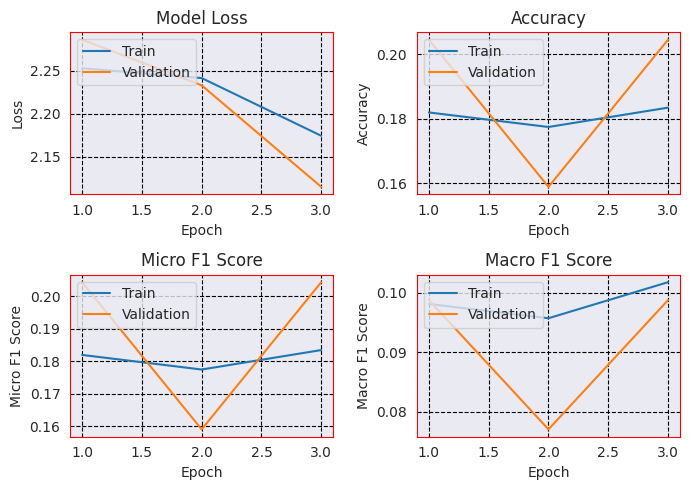

In [28]:
# visualisation
def plot_metric(ax, x, y_train, y_val, title, ylabel, xlabel):
    ax.plot(x, y_train, label='Train')
    ax.plot(x, y_val, label='Validation')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(loc='upper left')

def plot_history(history):
    # 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(7, 5))  # Adjust figsize for better visibility

    # Epochs
    epochs = range(1, len(history.history['loss']) + 1)

    # Loss
    plot_metric(axs[0, 0], epochs, history.history['loss'], history.history['val_loss'], 
                'Model Loss', 'Loss', 'Epoch')
    # Accuracy
    plot_metric(axs[0, 1], epochs, history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                'Accuracy', 'Accuracy', 'Epoch')

    # Micro F1 Score
    plot_metric(axs[1, 0], epochs, history.history['f1_micro_metric'], history.history['val_f1_micro_metric'], 
                'Micro F1 Score', 'Micro F1 Score', 'Epoch')

    # Macro F1 Score
    plot_metric(axs[1, 1], epochs, history.history['f1_macro_metric'], history.history['val_f1_macro_metric'], 
                'Macro F1 Score', 'Macro F1 Score', 'Epoch')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_history(history)

In [65]:
# making Predictions on test data
predictions = model.predict(test_dataset_bt, verbose=1)

2500/2500 [==============================] - 422s 165ms/step


In [72]:
# convert one-hot encoded predictions to integer labels
predicted_integer_labels = np.array(tf.argmax(predictions.logits, axis=1))

# revert the integer labels back to string labels using the encoder's inverse_transform method
predicted_string_labels = list(map(hm_class.get, predicted_integer_labels))

In [ ]:
# clearly our submissions are evaluated on the basis of F1Score
submission = pd.DataFrame({'Id' : test_df.id}, columns = ['Id'])
submission['Predicted'] = predicted_string_labels
submission.to_csv('predicted.csv', index=False)